# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [3]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tflearn as tflearn
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print "TensorFlow Version {}".format(tf.__version__)

TensorFlow Version 1.3.0


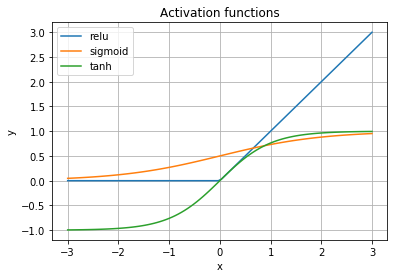

In [4]:
%reload_ext autoreload
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [5]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.3.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [6]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
    train_data=None
    train_labels=None
    for x in xrange(5):
        batch_file = "data/cifar-10-batches-py/data_batch_" + str(x+1)
        dict_data, dict_labels = unpickle(batch_file)
        if train_data is None:
            train_data = dict_data
        else: 
            train_data = np.vstack((train_data, dict_data))
        if train_labels is None:
            train_labels = dict_labels
        else: 
            train_labels = np.hstack((train_labels, dict_labels))
    train_data = train_data.reshape(50000, 32, 32, 3)
    X_train, X_val = np.vsplit(train_data, [49000])
    Y_train, Y_val = np.hsplit(train_labels, [49000])
    return (X_train, Y_train, X_val, Y_val)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():
    

    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
    test_data=None
    test_labels=None
    batch_file = "data/cifar-10-batches-py/test_batch"
    test_data, test_labels = unpickle(batch_file)
    test_data = test_data.reshape(10000, 32, 32, 3)
    test_labels = np.asarray(test_labels)
    return (test_data, test_labels)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [10]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.contrib.layers.xavier_initializer_conv2d(uniform=True,
    seed=None,
    dtype=tf.float32))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################



#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional nueral network

In [32]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 2
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)           
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = None
        p2_dims = self.pool2.get_shape()
        p2_dims_tuple = tuple([p2_dims[i].value for i in range(0, len(p2_dims))])
        self.flat = tf.reshape(self.pool2, [-1, np.prod(p2_dims_tuple[1:])])
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))
        
        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            #pass through activation function encapsulated in fully connected
            self.fc3 = tf.contrib.layers.fully_connected(self.flat, 384, normalizer_fn=tf.contrib.layers.batch_norm)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.fc3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = tf.contrib.layers.fully_connected(self.fc3, 10, normalizer_fn=tf.contrib.layers.batch_norm, activation_fn=None)            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = None
        self.keep_prob = None
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################

        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 5e-4
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(learning_rate=5e-4, epsilon=1e-08, use_locking=False, name='Adam').minimize(self.loss_op, global_step=global_step)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        cross_entropy_with_logits = tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits) 
        self.loss_op = tf.reduce_mean(tf.cast(cross_entropy_with_logits, tf.float32))       
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X: X_, self.Y: Y_}                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            plt.subplot(2, 1, 1)
            # Graph 1. X: epoch, Y: training loss
            plt.title('Loss')
            
            plt.plot((np.arange(len(losses)) / float(num_training // self.batch_size)),losses, '-o', label='Training')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.gcf().set_size_inches(15, 12)
            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(2, 1, 2)
            plt.title('Accuracy')
            plt.plot((np.arange(len(accuracies)) / float(num_training // self.batch_size)), accuracies, '-o', label='Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.gcf().set_size_inches(15, 12)
            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
        plt.show()
    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y: Y_}    
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.751, accuracy = 0.125
iteration (50): loss = 1.638, accuracy = 0.438
iteration (100): loss = 1.506, accuracy = 0.516
iteration (150): loss = 1.542, accuracy = 0.398
iteration (200): loss = 1.540, accuracy = 0.453
iteration (250): loss = 1.445, accuracy = 0.508
iteration (300): loss = 1.411, accuracy = 0.547
iteration (350): loss = 1.425, accuracy = 0.531
validation for epoch 0
-  epoch 0: validation accuracy = 0.576
train for epoch 1
iteration (400): loss = 1.277, accuracy = 0.602
iteration (450): loss = 1.371, accuracy = 0.547
iteration (500): loss = 1.373, accuracy = 0.516
iteration (550): loss = 1.202, accuracy = 0.648
iteration (600): loss = 1.226, accuracy = 0.609
iteration (650): loss = 1.286, accuracy = 0.578
iteration (700): loss = 1.259,

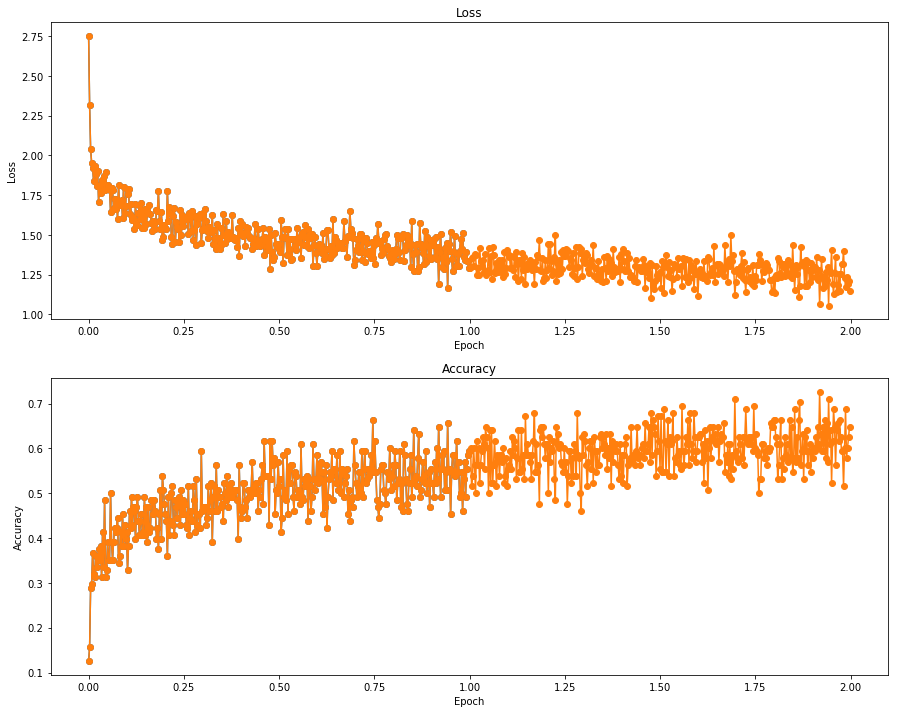

***** test accuracy: 0.587
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [12]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [36]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 70
    
    
    
    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)
        #############################################################################
        # TODO: Implement you own model here                                        #
        #############################################################################

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 3, 1, 48)
            self.relu1 = tf.nn.relu(self.conv1)    
            print('conv1 layer: ' + str(self.relu1.get_shape()))
    
        
        
        
        with tf.variable_scope('conv2'):
                self.conv2 = conv2d(self.relu1, 3, 1, 48)
                self.relu2 = tf.nn.relu(self.conv2)
                self.pool2 = max_pool(self.relu2, 2, 2)            

                self.dropout2 = tf.nn.dropout(self.pool2, self.keep_prob)
                print('conv2 layer: ' + str(self.dropout2.get_shape()))


        
        
        with tf.variable_scope('conv3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv3 = conv2d(self.dropout2, 3, 1, 96)
            self.relu3 = tf.nn.relu(self.conv3)        
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv3 layer: ' + str(self.relu3.get_shape()))



        
        
        with tf.variable_scope('conv4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv4 = conv2d(self.conv3, 3, 1, 96)
            self.relu4 = tf.nn.relu(self.conv3)  
            self.pool4 = max_pool(self.relu3, 2, 2)
            self.dropout4 = tf.nn.dropout(self.pool4, self.keep_prob)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv4 layer: ' + str(self.dropout4.get_shape()))


        
        
        with tf.variable_scope('conv5'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv5 = conv2d(self.dropout4, 3, 1, 192)
            self.relu5 = tf.nn.relu(self.conv5) 
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv5 layer: ' + str(self.relu5.get_shape()))


        
        
        with tf.variable_scope('conv6'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv6 = conv2d(self.relu5, 3, 1, 192)
            self.relu6 = tf.nn.relu(self.conv6) 
            self.pool6 = max_pool(self.relu6, 2, 2)
            self.dropout6 = tf.nn.dropout(self.pool6, self.keep_prob)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv6 layer: ' + str(self.dropout6.get_shape()))    


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = None
        d7_dims = self.dropout6.get_shape()
        d7_dims_tuple = tuple([d7_dims[i].value for i in range(0, len(d7_dims))])
        self.flat = tf.reshape(self.dropout6, [-1, np.prod(d7_dims_tuple[1:])])
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))



        with tf.variable_scope('fc8'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            #pass through activation function encapsulated in fully connected
            self.fc8 = tf.contrib.layers.fully_connected(self.flat, 512, normalizer_fn=tf.contrib.layers.batch_norm)
            self.fc8_dropout = tf.nn.dropout(self.fc8, self.keep_prob)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc8 layer: ' + str(self.fc8.get_shape()))


        with tf.variable_scope('fc9'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc9 = tf.contrib.layers.fully_connected(self.fc8_dropout, 256, normalizer_fn=tf.contrib.layers.batch_norm)            
            self.fc9_dropout = tf.nn.dropout(self.fc9, self.keep_prob)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc9 layer: ' + str(self.fc9.get_shape()))


        with tf.variable_scope('logits'):
            self.logits = tf.contrib.layers.fully_connected(self.fc9_dropout, 10, normalizer_fn=tf.contrib.layers.batch_norm, activation_fn=None) 
            print('logits layer: ' + str(self.logits.get_shape()))


        # Return the last layer
        return self.logits
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################

        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 5e-4
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,500, 0.97, staircase=True)
        self.train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=1e-08, use_locking=False, name='Adam').minimize(self.loss_op, global_step=global_step)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    #############################################################################
    # TODO: You can redefine BaseModel's methods                                #
    #############################################################################
    def _input_ops(self):
        # Placeholders
#         img_prep = tflearn.ImagePreprocessing()
#         img_prep.add_featurewise_zero_center()
#         img_prep.add_featurewise_stdnorm()
#         img_prep.add_zca_whitening()
        self.X = tf.placeholder(tf.int64, shape=[None, 32, 32, 3])
        self.X = tf.reshape(self.X, [-1, 96, 96])

        #data preprocessing
        self.X = tf.image.random_flip_left_right(self.X)
        self.X = tf.image.random_brightness(self.X, max_delta=63)
        self.X = tf.image.random_contrast(self.X, lower=0.2, upper=1.8)
        self.X = tf.image.per_image_standardization(self.X)
        self.X = tf.reshape(self.X, [-1, 32, 32, 3])
        print "question 2.2 input_ops operation run"
        self.Y = tf.placeholder(tf.int64, [None])
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.keep_prob = tf.placeholder(tf.float32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    def train(self, sess, X_train, Y_train, X_val, Y_val, dropout_param):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X: X_, self.Y: Y_, self.keep_prob: dropout_param}                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            plt.subplot(2, 1, 1)
            # Graph 1. X: epoch, Y: training loss
            plt.title('Loss')
            
            plt.plot((np.arange(len(losses)) / float(num_training // self.batch_size)),losses, '-o', label='Training')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.gcf().set_size_inches(15, 12)
            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(2, 1, 2)
            plt.title('Accuracy')
            plt.plot((np.arange(len(accuracies)) / float(num_training // self.batch_size)), accuracies, '-o', label='Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.gcf().set_size_inches(15, 12)
            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
        plt.show()
    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y: Y_, self.keep_prob: 1.0}    
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

In [42]:


# Clear old computation graphs
#tf.reset_default_graph()
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)

#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
X_train_ = X_train
X_val_ = X_val
X_test_ = X_test
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

model = YourModel()

#model.train(sess, X_train_, Y_train, X_val_, Y_val,  0.5)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

question 2.2 input_ops operation run
-----  Your model  -----


ValueError: Variable conv1/w already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-10-06ccc0fbf139>", line 8, in conv2d
    dtype=tf.float32))
  File "<ipython-input-36-e52e0302c236>", line 15, in _model
    self.conv1 = conv2d(self.X, 3, 1, 48)
  File "<ipython-input-32-93c086003eed>", line 116, in _build_model
    logits = self._model()


# Dear Grader, although I am turning in a notebook where it does not show over 70% accuracy, try running it if you have a GPU. In about 70 epochs which I defined above, it should definitely surpass 70% accuracy. I tried running the model up to 50 epochs and got 72% validation accuracy. However, I needed to go up to 70 epochs and it was to late (submitting 1 hr before the deadline) and I interrupted my kernel. I had to run this on my CPU so there was no way to get around this issue, and I spent five days trying to figure how to make this work effectively because I tried to get this to work under 20 epochs which is why I am submitting this late. Among the things I tried: 1) I implemented the All conv net paper's architecture (with the 8*8 averaging before the logits layer) 2) then I ended up trying the architecture I implemented above I found after reading a blog. 3) of course I did the standard data normalization, changed the learning rate, and tried modifying the learning rate decay algorithm  4) I tried installing an OpenCL wrapper for CUDA for the GPU on my machine (AMD Radeon 560) but learnt that it isn't supported after going far into the process because there is no compute.cpp for MAC OSX. 5) I briefly started taking tutorials on Google cloud platform but realized it didn't really make sense for this assignment either. I just wanted to make sure I share this information because I think it would be unfair if it is just what is outputted currently on my notebook that is taken into account 

In [ ]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")